# P5 Workout

In [1]:
import sys
import pickle
sys.path.append("tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [2]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

## Detecting and Removing Outliers

Populating the interactive namespace from numpy and matplotlib
Total Rows :  146
Total POIs :  18


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


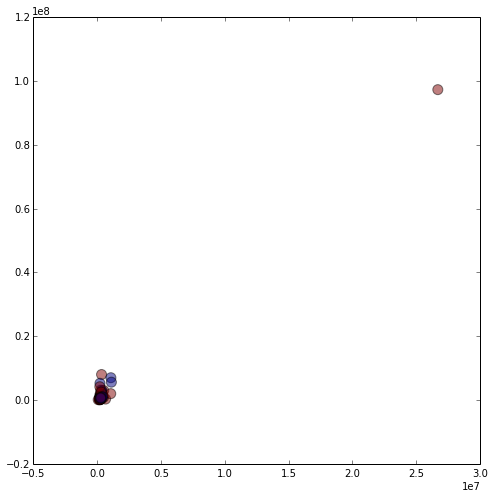

In [3]:

import numpy as np
import matplotlib.pyplot as plt

salary=[]
bonus=[]
colors_=[]
%pylab inline
count=0

for k,v in data_dict.iteritems():
    salary.append(data_dict[k]['salary'])
    bonus.append(data_dict[k]['bonus'])
    if data_dict[k]['poi']:
        count+=1
        colors_.append(0)
    else:
        colors_.append(1)
print 'Total Rows : ',len(data_dict)
print 'Total POIs : ',count


plt.figure(figsize=(8, 8))
matplotlib.pyplot.scatter( salary, bonus,c=colors_, alpha=0.5,s=100 )

del data_dict['TOTAL']

Total Rows :  145
Total POIs :  18


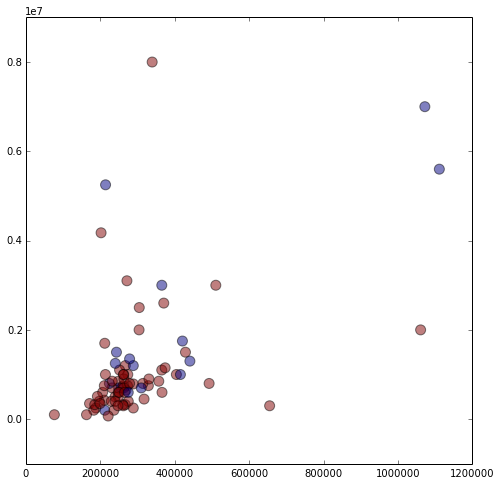

In [4]:
salary=[]
colors_=[]
bonus=[]
count=0
for k,v in data_dict.iteritems():
    salary.append(data_dict[k]['salary'])
    bonus.append(data_dict[k]['bonus'])
    if data_dict[k]['poi']:
        count+=1
        colors_.append(0)
    else:
        colors_.append(50)
print 'Total Rows : ',len(data_dict)
print 'Total POIs : ',count


plt.figure(figsize=(8, 8))
matplotlib.pyplot.scatter( salary, bonus,c=colors_, alpha=0.5,s=100 )

## Creating New Features 


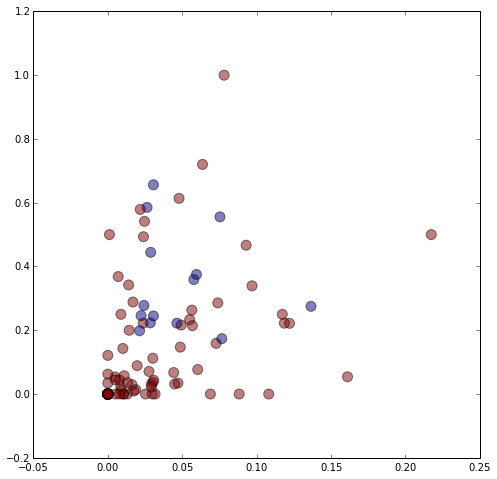

In [5]:
def compute_fraction( poi_messages, all_messages ):
    fraction = 0.
    if poi_messages!='NaN':
        fraction=int(poi_messages)/float(all_messages)
    return fraction
from_poi=[]
to_poi=[]
for k,v in data_dict.iteritems():
    data_dict[k]['fraction_from_poi']=compute_fraction(data_dict[k]['from_poi_to_this_person'],data_dict[k]['to_messages'])
    data_dict[k]['fraction_to_poi']=compute_fraction(data_dict[k]['from_this_person_to_poi'],data_dict[k]['from_messages'])
    from_poi.append(data_dict[k]['fraction_from_poi'])
    to_poi.append(data_dict[k]['fraction_to_poi'])

plt.figure(figsize=(8, 8))
matplotlib.pyplot.scatter(from_poi, to_poi,c=colors_, alpha=0.5,s=100 )


## Selecting Best 5 Features


In [11]:

from sklearn.feature_selection import SelectKBest,f_classif
import numpy as np
import seaborn as sns

features_list = ['poi','salary','bonus','deferred_income','director_fees','exercised_stock_options'
                ,'expenses','fraction_from_poi','fraction_to_poi','loan_advances','long_term_incentive'
                 ,'restricted_stock','total_payments','total_stock_value' ,'deferral_payments'
                 ,'restricted_stock_deferred','shared_receipt_with_poi']

f_arr=featureFormat(data_dict,features_list)
target,features=targetFeatureSplit(f_arr)

print features[0]

[  3.65788000e+05   6.00000000e+05   0.00000000e+00   0.00000000e+00
   0.00000000e+00   9.42990000e+04   4.70879802e-02   3.44827586e-02
   0.00000000e+00   0.00000000e+00   5.85062000e+05   1.06182700e+06
   5.85062000e+05   0.00000000e+00   0.00000000e+00   7.02000000e+02]


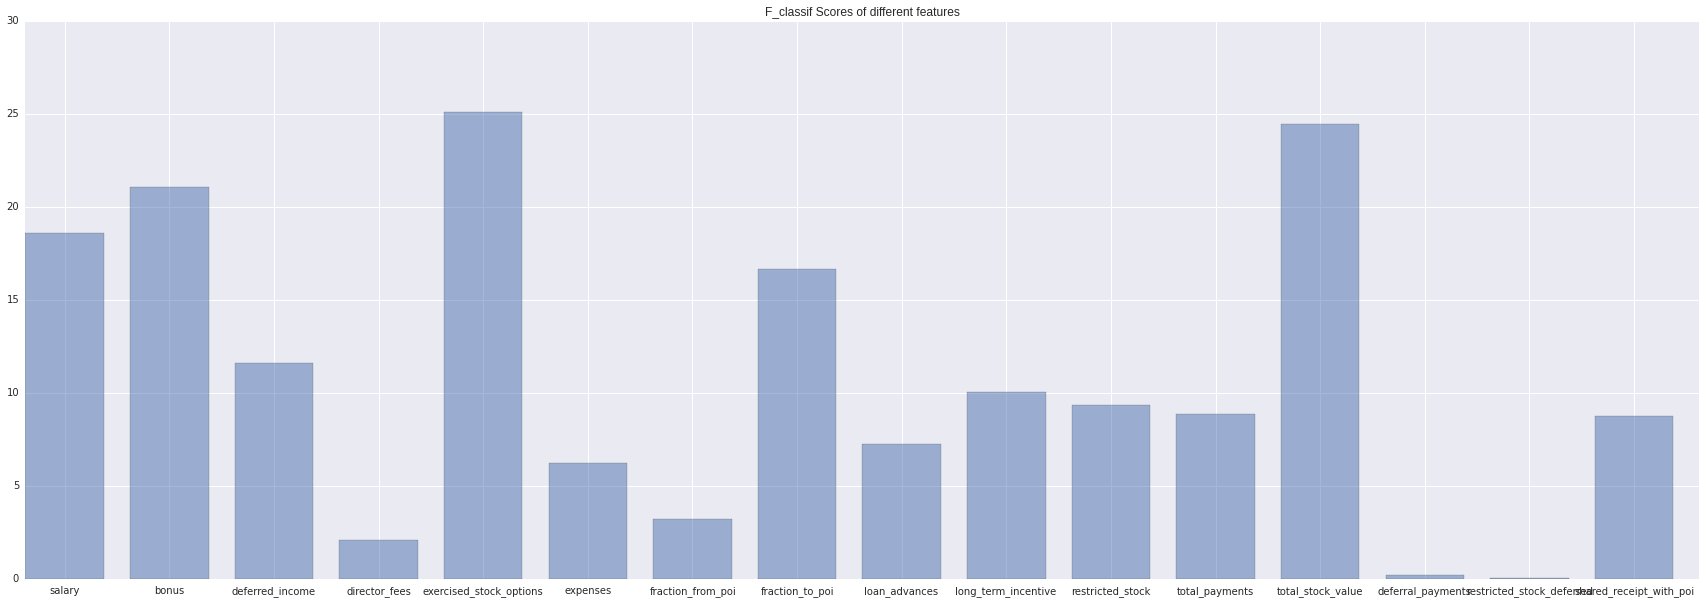

In [14]:
selector=SelectKBest(f_classif, k=5)
features_best=selector.fit_transform(features, target)

ind = np.arange(16)    
width = .75
plt.figure(figsize=(30, 10))
matplotlib.pyplot.bar(ind,selector.scores_,width, alpha=0.5 )
plt.xticks(ind + width/2., features_list[1:])
plt.title('F_classif Scores of different features')
plt.show()


In [28]:
import operator
features_by_score={}
for i in xrange(0,13):
    features_by_score[features_list[i+1]]=selector.scores_[i]

sorted_features = sorted(features_by_score.items(), key=operator.itemgetter(1),reverse=True)

for item in sorted_features[:5]:
    print item[0]+'  ->   '+str(item[1])

exercised_stock_options  ->   25.0975415287
total_stock_value  ->   24.4676540475
bonus  ->   21.0600017075
salary  ->   18.575703268
fraction_to_poi  ->   16.6417070705


## Scale Features

In [30]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
min_max_scaler = preprocessing.MinMaxScaler()
features_best_scaled=min_max_scaler.fit_transform(features_best)
pipeline =  Pipeline(steps=[('scaling', min_max_scaler),("kbest", selector), ("GaussianNB", GaussianNB())])

## Classifiers

        GassuianNB
        LinearSVC
        DecisionTree
        AdaBoost

In [37]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
ftrain, ftest, ltrain, ltest = train_test_split(features, target, test_size=0.3, random_state=42)

In [38]:
from sklearn.naive_bayes import GaussianNB
# clf1 = GaussianNB()
# clf1.fit(ftrain,ltrain)
pipeline.fit(ftrain,ltrain)
pred=pipeline.predict(ftest)
print ' GaussianNB Performance'
print '------------------------------------'
print 'Precision ',metrics.precision_score(ltest,pred)
print 'Recall ',metrics.recall_score(ltest,pred)
print 'F1_score ',metrics.f1_score(ltest,pred)

 GaussianNB Performance
------------------------------------
Precision  0.25
Recall  0.25
F1_score  0.25


In [39]:
from sklearn import svm
pipeline_svm =  Pipeline(steps=[('scaling', min_max_scaler),("kbest", selector), ("SVC", svm.SVC())])
# clf2 = svm.LinearSVC()
# clf2.fit(ftrain,ltrain)
pipeline_svm.fit(ftrain,ltrain)
pred=pipeline_svm.predict(ftest)
print 'Linear SVM Performance'
print '------------------------------------'
print 'Precision ',metrics.precision_score(ltest,pred)
print 'Recall ',metrics.recall_score(ltest,pred)
print 'F1_score ',metrics.f1_score(ltest,pred)

Linear SVM Performance
------------------------------------
Precision  0.0
Recall  0.0
F1_score  0.0


In [40]:

from sklearn.tree import DecisionTreeClassifier
pipeline_dtree =  Pipeline(steps=[('scaling', min_max_scaler),("kbest", selector), ("SVC", DecisionTreeClassifier())])
clf3 = DecisionTreeClassifier(random_state=0)
pipeline_dtree.fit(ftrain,ltrain)
pred=pipeline_dtree.predict(ftest)
print 'Decision Tree Performance'
print '------------------------------------'
print 'Precision ',metrics.precision_score(ltest,pred)
print 'Recall ',metrics.recall_score(ltest,pred)
print 'F1_score ',metrics.f1_score(ltest,pred)

Decision Tree Performance
------------------------------------
Precision  0.4
Recall  0.5
F1_score  0.444444444444


In [41]:
from sklearn.ensemble import AdaBoostClassifier
clf4=AdaBoostClassifier()
clf4.fit(ftrain,ltrain)
pred=clf4.predict(ftest)
print 'AdaBoost Performance'
print '------------------------------------'
print 'Precision ',metrics.precision_score(ltest,pred)
print 'Recall ',metrics.recall_score(ltest,pred)
print 'F1_score ',metrics.f1_score(ltest,pred)

AdaBoost Performance
------------------------------------
Precision  0.333333333333
Recall  0.125
F1_score  0.181818181818


## Algorithm Tuning


In [17]:
parameters = {'criterion':('gini', 'entropy'),'min_samples_split':list(xrange(3,5)),'min_samples_leaf':list(xrange(3,10))}
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
clf = DecisionTreeClassifier(random_state=0)
clf.fit(ftrain,ltrain)
print clf
pred=clf.predict(ftest)
print 'Decision Tree Performance'
print '------------------------------------'
print 'Precision ',metrics.precision_score(ltest,pred)
print 'Recall ',metrics.recall_score(ltest,pred)
print 'F1_score ',metrics.f1_score(ltest,pred)


clf_tuned = GridSearchCV(clf, parameters,scoring='f1')
clf_tuned.fit(ftrain,ltrain)
print clf_tuned
pred=clf_tuned.predict(ftest)
print 'Decision Tree Performance'
print '------------------------------------'
print 'Precision ',metrics.precision_score(ltest,pred)
print 'Recall ',metrics.recall_score(ltest,pred)
print 'F1_score ',metrics.f1_score(ltest,pred)
print clf_tuned.best_params_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
Decision Tree Performance
------------------------------------
Precision  0.363636363636
Recall  0.5
F1_score  0.421052631579
GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [3, 4], 'criterion': ('gini', 'entropy'), 'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)
Decision Tree Performance
--------

In [21]:
features_list_final=['poi','exercised_stock_options' ,'total_stock_value', 'bonus' ,'salary','fraction_to_poi']


### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf_tuned, data_dict, features_list_final)